<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W1D5_DeepLearning/student/W1D5_Tutorial2.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D5_DeepLearning/student/W1D5_Tutorial2.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Tutorial 2: Convolutional Neural Networks

**Week 1, Day 5: Deep Learning**

**By Neuromatch Academy**

**Content creators**: Jorge A. Menendez, Carsen Stringer

**Content reviewers**: Roozbeh Farhoodi,  Madineh Sarvestani, Kshitij Dwivedi, Spiros Chavlis, Ella Batty, Michael Waskom

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

*Estimated timing of tutorial: 40 minutes*

In this short tutorial, we'll go through an introduction to 2D convolutions and apply a convolutional network to an image to prepare for creating normative models in Tutorial 3.

In this tutorial, we will 
* Understand the basics of 2D convolution
* Build a convolutional layer using PyTorch
* Visualize and analyze its outputs


##  Tutorial slides


 These are the slides for all videos in this tutorial.


In [1]:
# @title Tutorial slides

# @markdown These are the slides for all videos in this tutorial.
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/s59jy/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup


In [2]:
# Imports
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from matplotlib import pyplot as plt
import matplotlib as mpl

##  Figure settings


In [3]:
# @title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

##  Data retrieval and loading


In [4]:
# @title Data retrieval and loading

import hashlib
import requests

fname = "W3D4_stringer_oribinned6_split.npz"
url = "https://osf.io/p3aeb/download"
expected_md5 = "b3f7245c6221234a676b71a1f43c3bb5"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

##  Plotting Functions


In [5]:
# @title Plotting Functions

def show_stimulus(img, ax=None):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img+0.5, cmap=mpl.cm.binary)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

def plot_weights(weights, channels=[0], colorbar=True):
  """ plot convolutional channel weights
  Args:
        weights: weights of convolutional filters (conv_channels x K x K)
        channels: which conv channels to plot
  """
  wmax = torch.abs(weights).max()
  fig, axs = plt.subplots(1,len(channels), figsize=(12,2.5))
  for i, channel in enumerate(channels):
    im = axs[i].imshow(weights[channel,0], vmin=-wmax, vmax=wmax, cmap='bwr')
    axs[i].set_title('channel %d'%channel)

  if colorbar:
    ax = fig.add_axes([1, 0.1, 0.05, 0.8])
    plt.colorbar(im, ax=ax)
    ax.axis('off')

def plot_example_activations(stimuli, act, channels=[0]):
  """ plot activations act and corresponding stimulus
  Args:
        stimuli: stimulus input to convolutional layer (n x h x w) or (h x w)
        act: activations of convolutional layer (n_bins x conv_channels x n_bins)
        channels: which conv channels to plot
  """
  if stimuli.ndim>2:
    n_stimuli = stimuli.shape[0]
  else:
    stimuli = stimuli.unsqueeze(0)
    n_stimuli = 1

  fig, axs = plt.subplots(n_stimuli,1+len(channels),figsize=(12,12))

  # plot stimulus
  for i in range(n_stimuli):
    show_stimulus(stimuli[i].squeeze(), ax=axs[i, 0])
    axs[i, 0].set_title('stimulus')

    # plot example activations
    for k, (channel, ax) in enumerate(zip(channels, axs[i][1:])):
      img=ax.imshow(act[i,channel], vmin=-3, vmax=3, cmap='bwr')
      ax.set_xlabel('x-pos')
      ax.set_ylabel('y-pos')
      ax.set_title('channel %d'%channel)
  ax = fig.add_axes([1.05,0.8,0.01,0.1])
  plt.colorbar(img, cax=ax)
  ax.set_title('activation\n strength')

##  Helper Functions


In [6]:
# @title Helper Functions

def load_data_split(data_name=fname):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. The repsonses were split into train and
  test and then each set were averaged in bins of 6 degrees.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  It will hold out some of the trials when averaging to allow us to have test
  tuning curves.

  Args:
    data_name (str): filename to load

  Returns:
    resp_train (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    resp_test (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp_train = data['resp_train']
  resp_test = data['resp_test']
  stimuli = data['stimuli']

  # Return as torch.Tensor
  resp_train_tensor = torch.tensor(resp_train, dtype=torch.float32)
  resp_test_tensor = torch.tensor(resp_test, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli, dtype=torch.float32)

  return resp_train_tensor, resp_test_tensor, stimuli_tensor


def filters(out_channels=6, K=7):
  """ make example filters, some center-surround and gabors
  Returns:
      filters: out_channels x K x K
  """
  grid = np.linspace(-K/2, K/2, K).astype(np.float32)
  xx,yy = np.meshgrid(grid, grid, indexing='ij')

  # create center-surround filters
  sigma = 1.1
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*sigma**2))
  wide_gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*2)**2))
  center_surround = gaussian - 0.5 * wide_gaussian

  # create gabor filters
  thetas = np.linspace(0, 180, out_channels-2+1)[:-1] * np.pi/180
  gabors = np.zeros((len(thetas), K, K), np.float32)
  lam = 10
  phi = np.pi/2
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*0.4)**2))
  for i,theta in enumerate(thetas):
    x = xx*np.cos(theta) + yy*np.sin(theta)
    gabors[i] = gaussian * np.cos(2*np.pi*x/lam + phi)

  filters = np.concatenate((center_surround[np.newaxis,:,:],
                            -1*center_surround[np.newaxis,:,:],
                            gabors),
                           axis=0)
  filters /= np.abs(filters).max(axis=(1,2))[:,np.newaxis,np.newaxis]
  filters -= filters.mean(axis=(1,2))[:,np.newaxis,np.newaxis]
  # convert to torch
  filters = torch.from_numpy(filters)
  # add channel axis
  filters = filters.unsqueeze(1)

  return filters


def grating(angle, sf=1 / 28, res=0.1, patch=False):
  """Generate oriented grating stimulus

  Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

  Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

  """

  angle = np.deg2rad(angle)  # transform to radians

  wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

  xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

  if patch:
    gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1
    xcent = gratings.shape[1] * .75
    ycent = gratings.shape[0] / 2
    xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
    icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
    gratings[~icirc] = 0.5

  else:
    gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1

  gratings -= 0.5

  # Return torch tensor
  return torch.tensor(gratings, dtype=torch.float32)

---
# Section 1: Introduction to 2D convolutions



## Section 1.1: What is a 2D convolution?

A 2D convolution is an integral of the product of a filter $f$ and an input image $I$ computed at various positions as the filter is slid across the input. The output of the convolution operation at position $(x,y)$ can be written as follows, where the filter $f$ is size $(K, K)$:

\begin{equation}
C(x,y) = \sum_{k_x=-K/2}^{K/2} \sum_{k_y=-K/2}^{K/2} f(k_x,k_y) I(x+k_x,y+k_y)
\end{equation}

This **convolutional filter** is often called a **kernel**.

Here is an illustration of a 2D convolution from this [article](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-convolution-neural-networks-e3f054dd5daa):

### 


 Execute this cell to view convolution gif


In [7]:
#@title
#@markdown Execute this cell to view convolution gif

from IPython.display import Image
Image(url='https://miro.medium.com/max/700/1*5BwZUqAqFFP5f3wKYQ6wJg.gif')

## Section 1.2: 2D convolutions in deep learning

*Estimated timing to here from start of tutorial: 6 min*


###  Video 1: 2D Convolutions


In [8]:
# @title Video 1: 2D Convolutions

from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1jw411d7Kg", width=730, height=410, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="zgO9rHYbDxE", width=730, height=410, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.titles = ['Youtube', 'Bilibili']

display(out)

This video covers convolutions and how to implement them in Pytorch.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

Recall Aude Oliva’s discussion of convolutions in the [intro](https://www.youtube.com/watch?v=IZvcy0Myb3M). Convolutional neural networks with several layers revolutionized the deep learning field, and in particular AlexNet, depicted here, was the first deep neural network to excel on the ImageNet classification task. The first layer in the network takes as input an image, runs convolutional filters on the image, rectifies the output, them downsamples the output (the pooling layer). The next layers repeat this process, and then at the end fully connected linear layers are attached which output a label for the image.  

The main advantages of convolutional layers over fully connected layers are the reduction in parameters through weight-sharing, which we will get into shortly, and also the fact that the units have local receptive fields. These local receptive fields allow the network to pool over units in spatial proximity and helps the network learn translation invariant representations.

A convolution is the integral of the product of two functions, one of which is a stimulus and the other which is a filter. This integral is computed at all positions by sliding the filter weights across the stimulus. If you want to perform a convolution and get the same output as the input you need to pad the input by half the filter size on each side. This is called “same” padding. Another parameter of this convolution computation is the stride -- how often the convolution is computed along the stimulus dimension. In this case, we use a stride of 1, but we can increase the stride and in turn have fewer units.

All the units of this filter are called a single output **channel**. A convolutional layer often consists of multiple output channels each with their own filter weights. We call the number of output convolutional channels $C_{out}$. 

We will implement this convolutional layer in pytorch. We will create a convolutional layer `ConvolutionalLayer` which takes as input a stimulus, which in our case are the gratings images. The convolutional layer is initialized with a few different parameters - first is the # of input channels $C_{in}$, which is 1 in our case. Next the number of convolutional channels which we’ll call $C_{out}$ which we can set to 6. Then the size of the filter $K$ which we set by default to 7. There’s also an optional `filters` input which we use to initialize the convolutional weights.  We set them as the weights of the conv layer we just created, and set the bias terms for the conv layer to zero.

We declare an `nn.conv2d` variable to be an attribute of the class `ConvolutionalLayer` called `conv`. For this convolutional layer we set the padding to half the filter size and the stride to 1 to get the same size output as the input.

What are some example filters we might use? One is a center-surround filter. It is positive in the middle and negative in the surround. Another is a gabor filter, which has a positive section next to a negative section. Look at the responses of these filters given the image. Both of these filter types are inspired by neurons recorded in the brain.

In fact, convolutional neural networks are inspired by the brain. In the retina there are a variety of cell types which we can think of as filters and each of these cells tile the entire visual space. The picture here shows the part of visual space each one of these cells responds to. In barrel cortex we have a similar situation where each whisker’s activation corresponds to a single cortical column of activity and the functions computed in each of these columns are similar.

</details>

Object recognition was essentially an unsolved problem in machine learning until the [advent](https://en.wikipedia.org/wiki/AlexNet) of techniques for effectively training *deep* convolutional neural networks. See Bonus Section 1 for more information on why we use CNNs to model the visual system.

Convolutional neural networks consist of 2D convolutional layers, ReLU non-linearities, 2D pooling layers, and at the output, a fully connected layer. We will see an example network with all these components in tutorial 3. 

A 2D convolutional layer has multiple output channels. Each output **channel** is the result of a 2D convolutional filter applied to the input. In the gif below, the input is in blue, the filter is in gray, and the output is in green. The number of units in the output channel depends on the *stride* you set. In the gif below, the stride is 1 because the input image is sampled at each position, a stride of 2 would mean skipping over input positions. In most applications, especially with small filter sizes, a stride of 1 is used.

(*Technical note*: if filter size *K* is odd and you set the *pad=K//2* and *stride=1* (as is shown below), you get a **channel** of units that is the same size as the input. See a more detailed explanation of strides and pads [here](https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html) if interested).

### 


 Execute this cell to view convolution gif


In [9]:
#@title
#@markdown Execute this cell to view convolution gif

from IPython.display import Image
Image(url='https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif')

## Section 1.3: 2D convolutions in Pytorch

*Estimated timing to here from start of tutorial: 18 min*

In Tutorial 1, fully connected linear layers were used to decode stimuli from neural activity. Convolutional layers are different from their fully connected counterparts in two ways:
  * In a fully connected layer, each unit computes a weighted sum over all the input units. In a convolutional layer, on the other hand, each unit computes a weighted sum over only a small patch of the input, referred to as the unit's **receptive field**. When the input is an image, the receptive field can be thought of as a local patch of pixels.
  * In a fully connected layer, each unit uses its own independent set of weights to compute the weighted sum. In a convolutional layer, all the units (within the same channel) **share the same weights**. This set of shared weights is called the **convolutional filter or kernel**. The result of this computation is a convolution, where each unit has computed the same weighted sum over a different part of the input. This reduces the number of parameters in the network substantially.

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/main/tutorials/static/weight-sharing.png?raw=true" width="700" />
</p>


We will compute the difference in the number of weights for a fully connected layer versus a convolutional layer in the Think exercise below.

First, let's visualize the stimuli in the dataset from tutorial 1. During the neural recordings from [Stringer _et al._, 2021](https://doi.org/10.1016/j.cell.2021.03.042), mice were presented oriented gratings:

 Execute this cell to plot example stimuli


stimulus size: 48 x 64


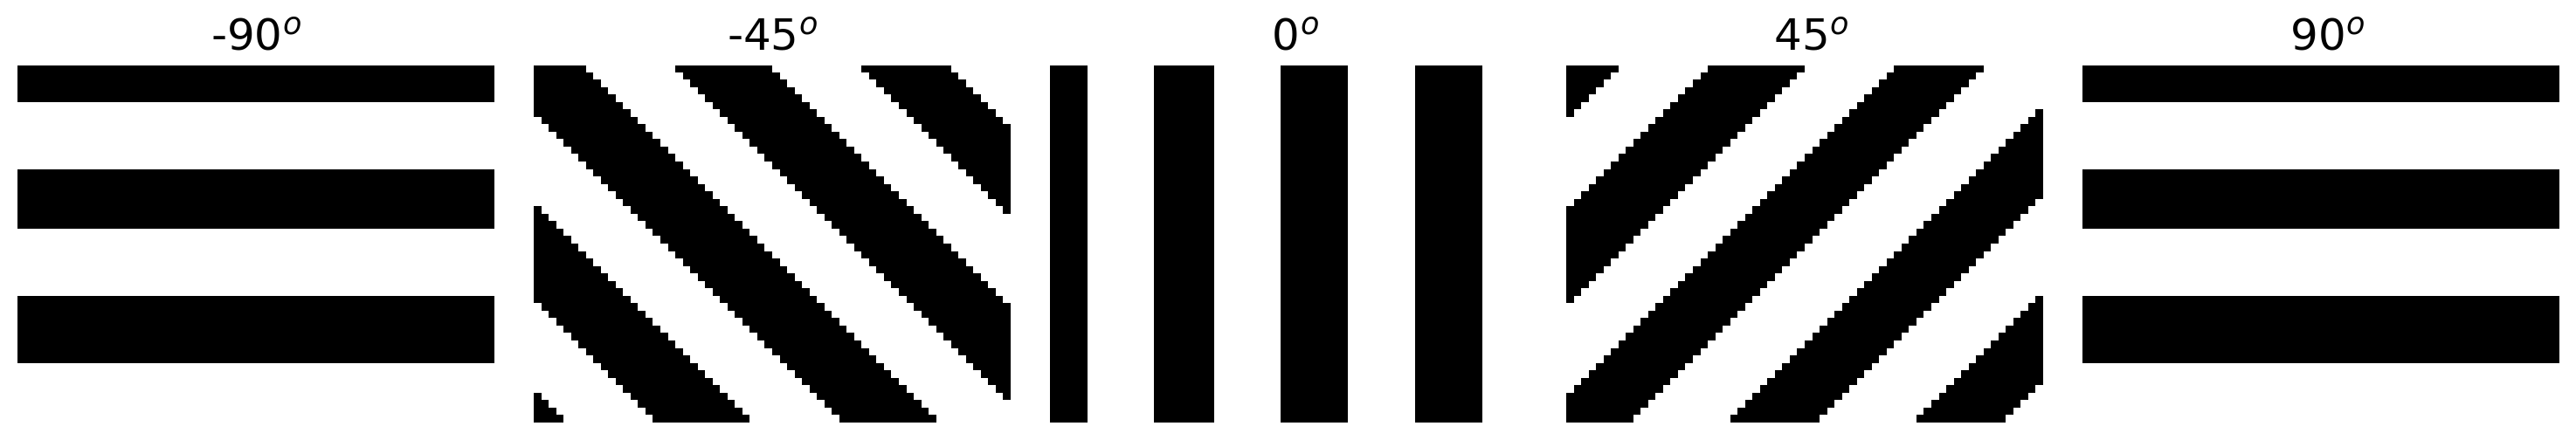

In [10]:
# @markdown Execute this cell to plot example stimuli

orientations = np.linspace(-90, 90, 5)

h = 3
n_col = len(orientations)
fig, axs = plt.subplots(1, n_col, figsize=(h * n_col, h))

h, w  = grating(0).shape  # height and width of stimulus
print('stimulus size: %i x %i' % (h, w))

for i, ori in enumerate(orientations):
  stimulus = grating(ori)
  axs[i].set_title(f'{ori: .0f}$^o$')
  show_stimulus(stimulus, axs[i])

Now let's implement 2D convolutional operations. We will use multiple convolutional channels and implement this operation efficiently using pytorch. A *layer* of convolutional channels can be implemented with one line of code using the PyTorch class `nn.Conv2d()`, which requires the following arguments for initialization (see full documentation [here](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html)):
  * $C^{in}$: the number of input channels
  * $C^{out}$: the number of output channels (number of different convolutional filters)
  * $K$: the size of the $C^{out}$ different convolutional filters
  
When you run the network, you can input a stimulus of arbitrary size $(H^{in}, W^{in})$, but it needs to be shaped as a 4D input $(N, C^{in}, H^{in}, W^{in})$, where $N$ is the number of images. In our case, $C^{in}=1$ because there is only one color channel (our images are grayscale, but often $C^{in}=3$ in image processing).

In [11]:
class ConvolutionalLayer(nn.Module):
  """Deep network with one convolutional layer
     Attributes: conv (nn.Conv2d): convolutional layer
  """
  def __init__(self, c_in=1, c_out=6, K=7, filters=None):
    """Initialize layer

    Args:
        c_in: number of input stimulus channels
        c_out: number of output convolutional channels
        K: size of each convolutional filter
        filters: (optional) initialize the convolutional weights

    """
    super().__init__()
    self.conv = nn.Conv2d(c_in, c_out, kernel_size=K,
                          padding=K//2, stride=1)
    if filters is not None:
      self.conv.weight = nn.Parameter(filters)
      self.conv.bias = nn.Parameter(torch.zeros((c_out,), dtype=torch.float32))

  def forward(self, s):
    """Run stimulus through convolutional layer

    Args:
        s (torch.Tensor): n_stimuli x c_in x h x w tensor with stimuli

    Returns:
        (torch.Tensor): n_stimuli x c_out x h x w tensor with convolutional layer unit activations.

    """
    a = self.conv(s)  # output of convolutional layer

    return a

See that `ConvolutionalLayer` takes as input `filters`. We have predesigned some filters that you can use by calling the `filters` function below. These are similar to filters we think are implemented in biological circuits such as the retina and the visual cortex. Some of them are **center-surround** filters and some of them are **gabor** filters. Check out this [website](http://www.cns.nyu.edu/~david/courses/perception/lecturenotes/ganglion/ganglion.html) for more details on center-surround filters, and this [website](https://en.wikipedia.org/wiki/Gabor_filter) for more details on gabor filters, if you're interested.



 Execute this cell to create and visualize filters


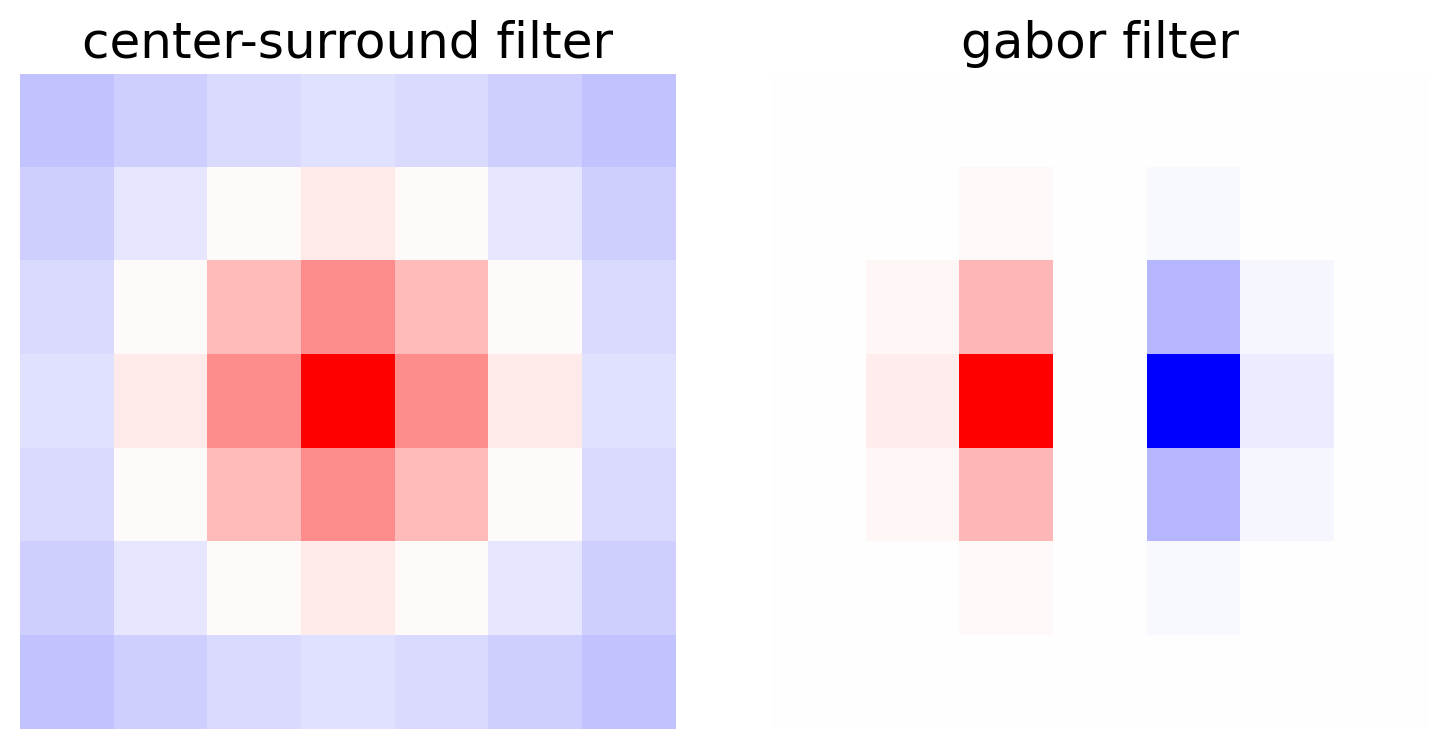

In [12]:
# @markdown Execute this cell to create and visualize filters

example_filters = filters(out_channels=6, K=7)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(example_filters[0,0], vmin=-1, vmax=1, cmap='bwr')
plt.title('center-surround filter')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(example_filters[4,0], vmin=-1, vmax=1, cmap='bwr')
plt.title('gabor filter')
plt.axis('off');

### Coding Exercise 1.3: 2D convolution in pytorch 

We will now run the convolutional layer on our stimulus. We will use gratings stimuli made using the function `grating`, which returns a stimulus which is 48 x 64. 

Reminder, `nn.Conv2d` takes in a tensor of size $(N, C^{in}, H^{in}, W^{in}$) where $N$ is the number of stimuli, $C^{in}$ is the number of input channels, and $(H^{in}, W^{in})$ is the size of the stimulus. We will need to add these first two dimensions to our stimulus, then input it to the convolutional layer.

We will plot the outputs of the convolution. `convout` is a tensor of size $(N, C^{out}, H^{in}, W^{in})$ where $N$ is the number of examples and $C^{out}$ are the number of convolutional channels. It is the same size as the input because we used a stride of 1 and padding that is half the kernel size.


In [13]:
# Stimulus parameters
in_channels = 1 # how many input channels in our images
h = 48 # height of images
w = 64 # width of images

# Convolution layer parameters
K = 7 # filter size
out_channels = 6 # how many convolutional channels to have in our layer
example_filters = filters(out_channels, K) # create filters to use

convout = np.zeros(0) # assign convolutional activations to convout

################################################################################
## TODO for students: create convolutional layer in pytorch
# Complete and uncomment
raise NotImplementedError("Student exercise: create convolutional layer")
################################################################################

# Initialize conv layer and add weights from function filters
# you need to specify :
# * the number of input channels c_in
# * the number of output channels c_out
# * the filter size K
convLayer = ConvolutionalLayer(..., filters=example_filters)

# Create stimuli (H_in, W_in)
orientations = [-90, -45, 0, 45, 90]
stimuli = torch.zeros((len(orientations), in_channels, h, w), dtype=torch.float32)
for i,ori in enumerate(orientations):
  stimuli[i,0] = grating(ori)

convout = convLayer(...)
convout = convout.detach() # detach gradients

plot_example_activations(stimuli, convout, channels=np.arange(0, out_channels))

NotImplementedError: Student exercise: create convolutional layer

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W1D5_DeepLearning/solutions/W1D5_Tutorial2_Solution_712d995b.py)

*Example output:*

<img alt='Solution hint' align='left' width=1907.0 height=1617.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D5_DeepLearning/static/W1D5_Tutorial2_Solution_712d995b_1.png>



### Think! 1.3: Output and weight shapes in a convolutional layer

Let's think about the shape of the weights and outputs of `convLayer`:
  - How many convolutional activations are there in each channel, and why is it this size?
  - How many weights does `convLayer` have? 
  - How many weights would it have if it were a fully connected layer?

Additionally, let's think about why the activations look the way they do. It seems like for all channels the activations are only non-zero for edges of the gratings (where the grating goes from white-to-black and from black-to-white).
  -  Channel 0 and 1 seem to respond to every edge regardless of the orientation, but their signs are different. What type of filter might produce these types of responses?
  - Channels 2-5 seem to respond differently depending on the orientation of the stimulus. What type of filter might produce these types of responses?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W1D5_DeepLearning/solutions/W1D5_Tutorial2_Solution_f48d6ecf.py)



Please see Bonus Section 2 to visualize the convolutional filter weights. See the Bonus Tutorial to use CNNs as encoding models of neurons (by fitting directly to neural responses).

---
# Summary

*Estimated timing of tutorial: 40 minutes*

In this notebook, we built a 2D convolutional layer which is meant to represent the responses of neurons in the mouse visual cortex, or the responses of neurons 
which are inputs to the mouse visual cortex.

In Tutorial 3, we will add to this 2D convolutional layer a fully-connected layer and train this model to predict whether an orientation is left or right. We will see if the convolutional filters it learns are similar to mouse visual cortex. See Section 3 in the Bonus Tutorial to fit convolutional neural networks directly to neural activity.

---
# Bonus

## Bonus Section 1: Why CNN's?

CNN models are particularly [well-suited](https://www.nature.com/articles/nn.4244) to modeling the visual system for a number of reasons:

1. **Distributed computation**: like any other neural network, CNN's use distributed representations to compute -- much like the brain seems to do. Such models, therefore, provide us with a vocabulary with which to talk and think about such distributed representations. Because we know the exact function the model is built to perform (e.g., orientation discrimination), we can analyze its internal representations with respect to this function and begin to interpret why the representations look the way they do. Most importantly, we can then use these insights to analyze the structure of neural representations observed in recorded population activity. We can qualitatively and quantitatively compare the representations we see in the model and in a given population of real neurons to hopefully tease out the computations it performs.

2. **Hierarchical architecture**: like in any other deep learning architecture, each layer of a deep CNN comprises a non-linear transformation of the previous layer. Thus, there is a natural hierarchy whereby layers closer to the network output represent increasingly more abstract information about the input image. For example, in a network trained to do object recognition, the early layers might represent information about edges in the image, whereas later layers closer to the output might represent various object categories. This resembles the [hierarchical structure of the visual system](https://pubmed.ncbi.nlm.nih.gov/1822724/), where [lower-level areas](https://www.jneurosci.org/content/25/46/10577.short) (e.g., retina, V1) represent visual features of the sensory input and [higher-level areas](https://www.sciencedirect.com/science/article/pii/S089662731200092X) (e.g., V4, IT) represent properties of objects in the visual scene. We can then naturally use a single CNN to model multiple visual areas, using early CNN layers to model lower-level visual areas and late CNN layers to model higher-level visual areas.
  
  Relative to fully connected networks, CNN's, in fact, have further hierarchical structure built-in through the max pooling layers. Recall that each output of a convolution + pooling block is the result of processing a local patch of the inputs to that block. If we stack such blocks in a sequence, then the outputs of each block will be sensitive to increasingly larger regions of the initial raw input to the network: an output from the first block is sensitive to a single patch of these inputs, corresponding to its "receptive field"; an output from the second block is sensitive to a patch of outputs from the first block, which together are sensitive to a larger patch of raw inputs comprising the union of their receptive fields. Receptive fields thus get larger for deeper layers (see [here](http://colah.github.io/posts/2014-07-Conv-Nets-Modular/) for a nice visual depiction of this). This resembles primate visual systems, where neurons in higher-level visual areas respond to stimuli in wider regions of the visual field than neurons in lower-level visual areas.

3. **Convolutional layers**: through the weight sharing constraint, the outputs of each channel of a convolutional layer process different parts of the input image in exactly the same way. This architectural constraint effectively builds into the network the assumption that objects in the world typically look the same regardless of where they are in space. This is useful for modeling the visual system for two (largely separate) reasons:
  * Firstly, this assumption is generally valid in mammalian visual systems, since mammals tend to view the same object from many perspectives. Two neurons at a similar hierarchy in the visual system with different receptive fields could thus end up receiving statistically similar synaptic inputs, so that the synaptic weights developed over time may end up being similar as well.
  * Secondly, this architecture significantly improves object recognition ability. Object recognition was essentially an unsolved problem in machine learning until the [advent](https://en.wikipedia.org/wiki/AlexNet) of techniques for effectively training *deep* convolutional neural networks. Fully connected networks on their own can't achieve object recognition abilities anywhere close to human levels, making them bad models of human object recognition. Indeed, it is generally the case that [the better a neural network model is at object recognition, the closer the match between its representations and those observed in the brain](https://www.pnas.org/content/111/23/8619.short). That said, it is worth noting that our much simpler orientation discrimination task (in Tutorial 3) can be solved by relatively simple networks.

---
## Bonus Section 2: Understanding activations from weight

### Bonus Coding Exercise 2: Visualizing convolutional filter weights

Why do the activations look the way they do? Let's look at the weights (`convLayer.conv.weight.detach()`) of the convolutional filters and try to interpret them.

In [14]:
################################################################################
## TODO for students: get weights
# Complete and uncomment
raise NotImplementedError("Student exercise: get weights")
################################################################################

# get weights of conv layer in convLayer
weights = ...
print(weights.shape) # can you identify what each of the dimensions are?

plot_weights(weights, channels=np.arange(0, out_channels))

NotImplementedError: Student exercise: get weights

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W1D5_DeepLearning/solutions/W1D5_Tutorial2_Solution_20c66403.py)

*Example output:*

<img alt='Solution hint' align='left' width=1890.0 height=340.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D5_DeepLearning/static/W1D5_Tutorial2_Solution_20c66403_2.png>



In the function `filters` we pre-made center-surround filters and Gabor filters of various orientations. [Gabor filters](https://en.wikipedia.org/wiki/Gabor_filter) have a positive region next to a negative region and the orientation of these regions of the filter determine the orientation of edges to which they respond. 

In the visual cortex, Hubel and Wiesel discovered simple cells, which would correspond to a unit in the channels 2-5 above with Gabor filters. There are also some neurons with activity that resemble center-surround filters, which would correspond to the first two convolutional channels above.

There were additional cells discovered by Hubel and Wiesel - complex cells - that respond to an oriented grating regardless of where the bars are exactly (note that the responses we see are specific to where the bars are). These cells therefore have some level of translation invariance. This is something that convolutional neural networks try to replicate -- e.g., a grating is still oriented horizontally even if it moves slightly, and a cat is still a cat even if it's in a different position in the image.

### Bonus Think! 2
  - How might you create a complex cell and have responses that are translation invariant?
  - How might you create a cell that responds to multiple orientations?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W1D5_DeepLearning/solutions/W1D5_Tutorial2_Solution_d290c523.py)

